# **Regression: Covid-19 Risk Prediction Notebook**

## Objectives

Fit and evaluate a regression model to predict the risk level for a Covid-19 patient based on their age and pre-existing health conditions.

## Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict Risk level of patient
* Labels map
* Feature Importance Plot 

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-covid-19-study/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-covid-19-study'

---

## Load Data

In [5]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/covid-19-dataset.csv")

binary_columns = ['SEX', 'INTUBED', 'PNEUMONIA', 'DIABETES', 
                  'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 
                  'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 
                  'RENAL_CHRONIC', 'TOBACCO', 'ICU', 'DIED']

df[binary_columns] = df[binary_columns].applymap(lambda x: 1 if x == "Yes" else 0)

categorical_columns = ['SEX', 'INTUBED', 'PNEUMONIA', 'DIABETES', 
                       'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 
                       'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 
                       'RENAL_CHRONIC', 'TOBACCO', 'ICU']

df[categorical_columns] = df[categorical_columns].astype('object')

df = df.drop(labels=['USMER', 'MEDICAL_UNIT'], axis=1)

print(df.shape)
df.head(3)

(62236, 16)


,SEX,INTUBED,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,DIED
0,0,0,0,76,0,0,0,0,1,1,0,0,0,0,0,0
1,0,0,1,91,1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,1,39,0,0,0,0,0,0,0,0,0,0,1,1


---

### ML Pipeline: Regressor

In [6]:
from sklearn.pipeline import Pipeline
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor

def PipelineOptimization(model):
    categorical_vars = ['SEX', 'INTUBED', 'PNEUMONIA', 'DIABETES', 
                        'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 
                        'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 
                        'RENAL_CHRONIC', 'TOBACCO', 'ICU']

    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(
            encoding_method='arbitrary',
            variables=categorical_vars
        )),
        
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(
            variables=None, method="spearman", threshold=0.6, selection_method="variance")),
        
        ("feat_scaling", StandardScaler()),
        
        ("feat_selection", SelectFromModel(model)),
        
        ("model", model),
    ])
    return pipeline_base

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Hyperparameter Optimization

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

class HyperparameterOptimizationSearch(BaseEstimator):
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

#### Split Train Test Set

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(['DIED'], axis=1)
y = df['DIED']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:", X_test.shape, y_test.shape)

* Train set: (49788, 15) (49788,) 
* Test set: (12448, 15) (12448,)


### Grid Search CV - Sklearn

In [9]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(),
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {
        'model__C': [0.1, 1, 10],
        'model__solver': ['liblinear', 'lbfgs'],
        'model__max_iter': [100, 200]
    },
    "LinearRegression": {},
    "DecisionTreeRegressor": {
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    "RandomForestRegressor": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__bootstrap': [True]
    },
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__bootstrap': [True]
    },
    "AdaBoostRegressor": {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.1, 1],
        'model__loss': ['linear', 'square']
    },
    "GradientBoostingRegressor": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.1, 0.2],
        'model__max_depth': [3, 5],
        'model__subsample': [0.8, 1.0],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    "XGBRegressor": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.1, 0.2],
        'model__max_depth': [3, 5],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    },
}

### Run Grid Search

In [10]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 64 candidates, totalling 320 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
print(grid_search_summary)

                    estimator min_score mean_score max_score std_score  \
12           LinearRegression  0.165624   0.171085  0.176591   0.00421   
86  GradientBoostingRegressor  0.160075   0.163936  0.168607  0.002932   
82  GradientBoostingRegressor    0.1601   0.163906  0.168607  0.002929   
94  GradientBoostingRegressor  0.160063   0.163897  0.168554  0.002904   
90  GradientBoostingRegressor    0.1601   0.163884  0.168554  0.002896   
..                        ...       ...        ...       ...       ...   
5          LogisticRegression -0.284394  -0.270556 -0.262576  0.008287   
10         LogisticRegression -0.284394  -0.270556 -0.262576  0.008287   
9          LogisticRegression -0.284394  -0.270556 -0.262576  0.008287   
6          LogisticRegression -0.284394  -0.270556 -0.262576  0.008287   
0          LogisticRegression -0.284394  -0.270556 -0.262576  0.008287   

   model__C model__max_iter model__solver model__max_depth  \
12      NaN             NaN           NaN        

### Evaluate the Best Model

In [12]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

best_model = grid_search_summary.iloc[0, 0]
print("Best Model:", best_model)
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_

regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)

Best Model: LinearRegression
Model Evaluation 

* Train Set
R2 Score: 0.173
Mean Absolute Error: 0.404
Mean Squared Error: 0.202
Root Mean Squared Error: 0.449


* Test Set
R2 Score: 0.177
Mean Absolute Error: 0.403
Mean Squared Error: 0.201
Root Mean Squared Error: 0.449




### Assess Feature Importance

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

columns_after_data_cleaning_feat_eng = X_train.columns

print(f"Number of features in X_train: {len(columns_after_data_cleaning_feat_eng)}")
print(f"Number of coefficients: {len(best_regressor_pipeline['model'].coef_)}")

selected_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()]

df_feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': np.abs(best_regressor_pipeline['model'].coef_)
}).sort_values(by='Importance', ascending=False)

print(f"* These are the {len(df_feature_importance)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

NameError: name 'X_train' is not defined

In [1]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance_1.png', bbox_inches='tight')

NameError: name 'df_feature_importance' is not defined

### Evaluate on Train and Test Sets

Model Evaluation 

* Train Set


R2 Score: 0.173
Mean Absolute Error: 0.404
Mean Squared Error: 0.202
Root Mean Squared Error: 0.449


* Test Set
R2 Score: 0.177
Mean Absolute Error: 0.403
Mean Squared Error: 0.201
Root Mean Squared Error: 0.449




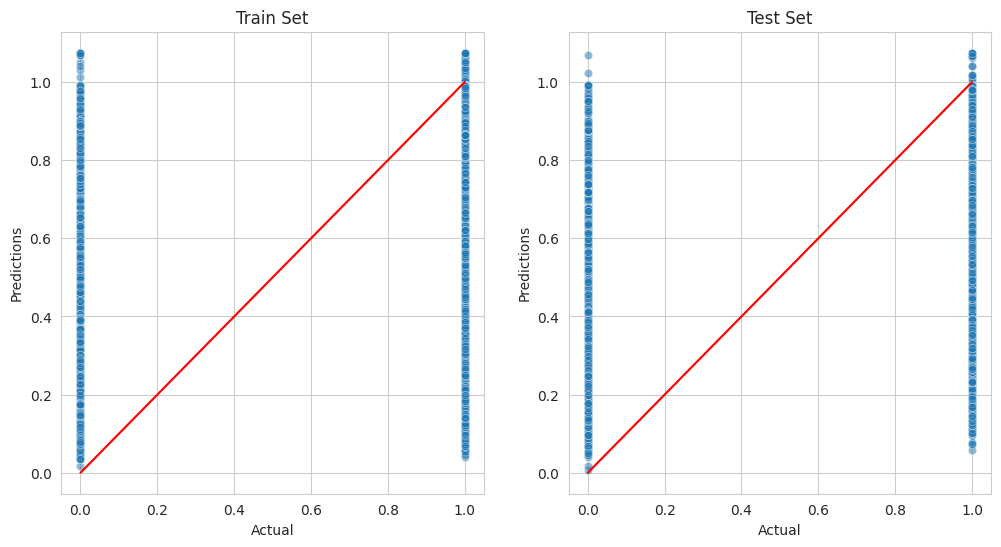

In [14]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()
    
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### Regressor with PCA

#### Modified Code for PCA Transformation

In [15]:
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(
            encoding_method='arbitrary',
            variables=['SEX', 'INTUBED', 'PNEUMONIA', 'DIABETES', 
                       'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 
                       'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 
                       'RENAL_CHRONIC', 'TOBACCO', 'ICU']
        )),
    
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(
            variables=None, 
            method="spearman", 
            threshold=0.6, 
            selection_method="variance")),
        
        ("feat_scaling", StandardScaler()),
        
        ("feat_selection", SelectFromModel(model)),
        
        ("model", model),
    ])
    
    return pipeline_base

In [16]:
pipeline = PipelineOptimization(model=LogisticRegression())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df.drop(['DIED'], axis=1))
print(df_pca.shape, '\n', type(df_pca))

(62236, 15) 
 <class 'numpy.ndarray'>


Apply PCA

* The 15 components explain 100.0% of the data 



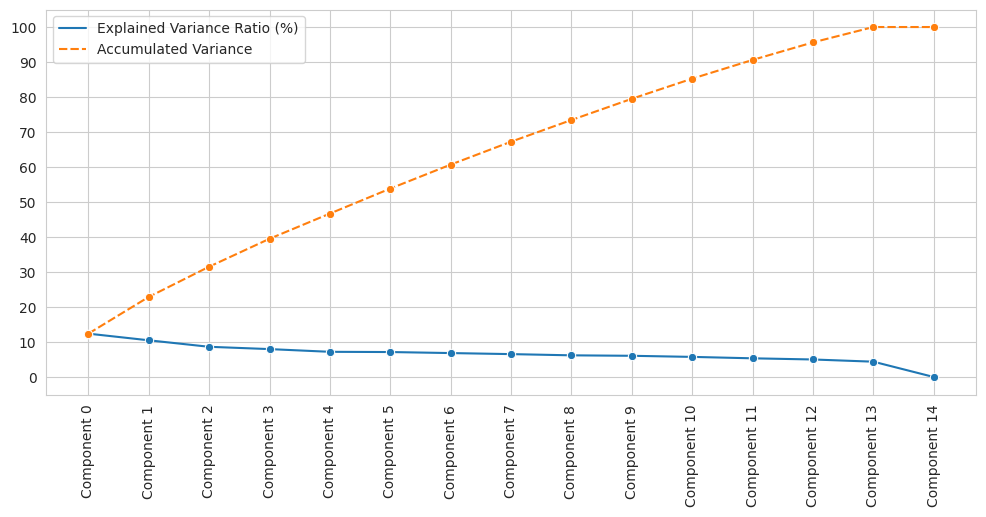

In [17]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 15


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca) 

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

* The 7 components explain 60.69% of the data 



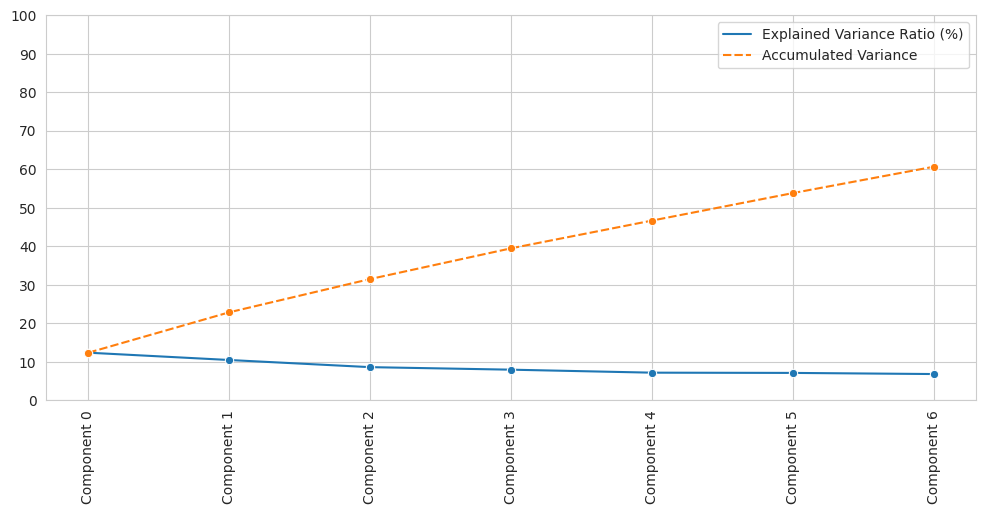

In [18]:
n_components = 7
pca_components_analysis(df_pca=df_pca, n_components=n_components)

### Rewrite ML Pipeline for Modelling

In [19]:
from sklearn.decomposition import PCA

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(
            encoding_method='arbitrary',
            variables=['SEX', 'INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA',
                       'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR',
                       'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']
        )),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),


        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", model),

    ])

    return pipeline_base

### Grid Search CV – Sklearn

In [20]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (49788, 15) (49788,) 
* Test set: (12448, 15) (12448,)


Use standard hyperparameters to find the most suitable model.

In [21]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(),
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {
        'model__C': [0.1, 1, 10],
        'model__solver': ['liblinear', 'lbfgs'],
        'model__max_iter': [100, 200]
    },
    "LinearRegression": {},
    "DecisionTreeRegressor": {
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    "RandomForestRegressor": {
    'model__n_estimators': [200],
    'model__max_depth': [None, 10],
    'model__min_samples_split': [2],
    'model__min_samples_leaf': [1],
    'model__bootstrap': [True]
    },
    "ExtraTreesRegressor": {
    'model__n_estimators': [200],
    'model__max_depth': [None, 10],
    'model__min_samples_split': [2],
    'model__min_samples_leaf': [1],
    'model__bootstrap': [True]
    },
    "AdaBoostRegressor": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.1, 1],
        'model__loss': ['linear', 'square']
    },
    "GradientBoostingRegressor": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.1],
        'model__max_depth': [3, 5],
        'model__subsample': [0.8, 1.0],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [1]
    },
    "XGBRegressor": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.1],
        'model__max_depth': [3, 5],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8]
    },
}

In [22]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 12 candidates, totalling 60 fits



Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 2 candidates, totalling 10 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 2 candidates, totalling 10 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [23]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__C,model__max_iter,model__solver,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__bootstrap,model__n_estimators,model__learning_rate,model__loss,model__subsample,model__colsample_bytree
50,XGBRegressor,0.141951,0.150163,0.157236,0.005293,NaN,NaN,NaN,5,NaN,NaN,NaN,100,0.1,NaN,1.0,0.8
28,ExtraTreesRegressor,0.142813,0.149933,0.156629,0.004814,NaN,NaN,NaN,10,1,2,True,200,NaN,NaN,NaN,NaN
42,GradientBoostingRegressor,0.14075,0.149648,0.157919,0.006482,NaN,NaN,NaN,5,1,2,NaN,100,0.1,NaN,1.0,NaN
41,GradientBoostingRegressor,0.141287,0.149236,0.155851,0.005539,NaN,NaN,NaN,5,1,2,NaN,100,0.1,NaN,0.8,NaN
26,RandomForestRegressor,0.140454,0.148722,0.154935,0.005015,NaN,NaN,NaN,10,1,2,True,200,NaN,NaN,NaN,NaN
49,XGBRegressor,0.14036,0.148353,0.155679,0.00536,NaN,NaN,NaN,5,NaN,NaN,NaN,100,0.1,NaN,0.8,0.8
52,XGBRegressor,0.139526,0.148177,0.156662,0.005883,NaN,NaN,NaN,5,NaN,NaN,NaN,200,0.1,NaN,1.0,0.8
44,GradientBoostingRegressor,0.137477,0.147169,0.15471,0.006378,NaN,NaN,NaN,5,1,2,NaN,200,0.1,NaN,1.0,NaN
43,GradientBoostingRegressor,0.136732,0.145803,0.153329,0.006277,NaN,NaN,NaN,5,1,2,NaN,200,0.1,NaN,0.8,NaN
39,GradientBoostingRegressor,0.137782,0.145384,0.151135,0.004933,NaN,NaN,NaN,3,1,2,NaN,200,0.1,NaN,0.8,NaN


##### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

In [24]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor":{
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10, None],
    }
}

In [25]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [26]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
1,GradientBoostingRegressor,0.136323,0.145605,0.151319,0.005466,0.1,3,300
0,GradientBoostingRegressor,0.133787,0.140465,0.145204,0.004473,0.1,3,100
9,GradientBoostingRegressor,0.127074,0.134612,0.14177,0.00509,0.01,10,300
8,GradientBoostingRegressor,0.124157,0.129971,0.134571,0.003494,0.01,10,100
7,GradientBoostingRegressor,0.121128,0.126653,0.13228,0.004754,0.01,3,300
2,GradientBoostingRegressor,0.108387,0.116003,0.122862,0.004876,0.1,10,100
6,GradientBoostingRegressor,0.093548,0.096959,0.100612,0.00292,0.01,3,100
3,GradientBoostingRegressor,0.062659,0.070961,0.075474,0.004571,0.1,10,300
15,GradientBoostingRegressor,0.068218,0.070844,0.072596,0.001442,0.001,10,300
13,GradientBoostingRegressor,0.046566,0.047643,0.049069,0.000876,0.001,3,300


In [27]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

In [28]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 300}

In [29]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['SEX', 'INTUBED', 'PNEUMONIA',
                                           'DIABETES', 'COPD', 'ASTHMA',
                                           'INMSUPR', 'HIPERTENSION',
                                           'OTHER_DISEASE', 'CARDIOVASCULAR',
                                           'OBESITY', 'RENAL_CHRONIC',
                                           'TOBACCO', 'ICU'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['SEX', 'INTUBED',
                                                     'PNEUMONIA', 'AGE',
                                                     'DIABETES', 'COPD',
            

#### Evaluate Regressor on Train and Tests Sets

Model Evaluation 

* Train Set
R2 Score: 0.179
Mean Absolute Error: 0.409
Mean Squared Error: 0.2
Root Mean Squared Error: 0.448


* Test Set
R2 Score: 0.147
Mean Absolute Error: 0.418
Mean Squared Error: 0.208
Root Mean Squared Error: 0.457




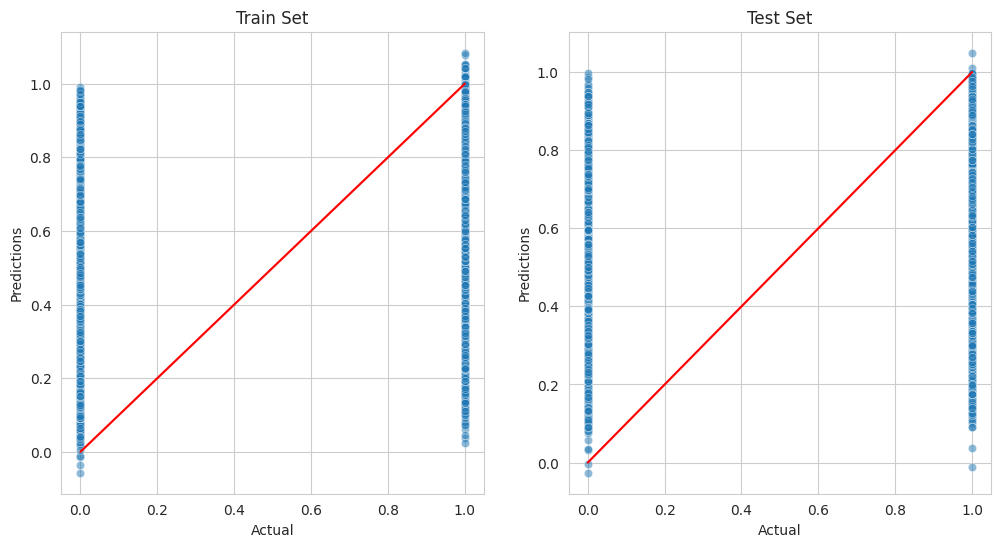

In [30]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

### Convert Regression to Classification

#### Convert numerical target to bins, and check if it is balanced

* The classes represent the following ranges: 
{'AGE': [-inf, 30.0, 41.0, 48.0, 53.0, 58.0, 63.0, 68.0, 73.0, 80.0, inf]} 



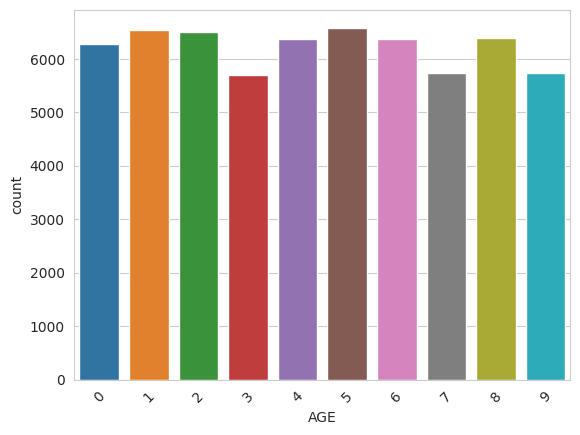

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from feature_engine.discretisation import EqualFrequencyDiscretiser

disc = EqualFrequencyDiscretiser(q=10, variables=['AGE'])
df_clf = disc.fit_transform(df)

print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")

sns.countplot(data=df_clf, x='AGE')
plt.xticks(rotation=45)
plt.show()

In [32]:
df_clf.head(3)

,SEX,INTUBED,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,DIED
0,0,0,0,8,0,0,0,0,1,1,0,0,0,0,0,0
1,0,0,1,9,1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1


### Rewrite ML Pipeline for Modelling

In [33]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['SEX', 'INTUBED', 'PNEUMONIA', 'DIABETES',
                                                                'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION',
                                                                'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
                                                                'RENAL_CHRONIC', 'TOBACCO', 'ICU'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

#### Load algorithms for classification

In [34]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

#### Split Train Test Sets

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['DIED'], axis=1),
    df['DIED'],
    test_size=0.2,
    random_state=0 
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (49788, 15) (49788,) 
* Test set: (12448, 15) (12448,)


### Grid Search CV – Sklearn

#### Use standard hyper parameters to find most suitable model

In [36]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

GridSearch CV

In [37]:
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check Results

In [38]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,XGBClassifier,0.40466,0.418938,0.427247,0.007938
1,DecisionTreeClassifier,0.398478,0.411139,0.421641,0.007554
4,ExtraTreesClassifier,0.398478,0.411139,0.421641,0.007554
2,RandomForestClassifier,0.395625,0.408903,0.418312,0.007565
3,GradientBoostingClassifier,0.393723,0.406954,0.413555,0.006848
5,AdaBoostClassifier,0.289893,0.394633,0.429624,0.052712


##### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define models and parameters

In [39]:
models_search = {
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_search = {
    "AdaBoostClassifier": {
        'model__n_estimators': [50, 100, 300],
        'model__learning_rate': [0.1, 0.01, 0.001],
    }
}

Extensive GridSearch CV

In [40]:
from sklearn.metrics import make_scorer,  recall_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Results

In [41]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
2,AdaBoostClassifier,0.398478,0.415181,0.429624,0.011144,0.1,300
1,AdaBoostClassifier,0.351724,0.40795,0.430338,0.028962,0.1,100
0,AdaBoostClassifier,0.268426,0.380847,0.432342,0.063568,0.1,50
5,AdaBoostClassifier,0.0,0.326808,0.430575,0.166031,0.01,300
3,AdaBoostClassifier,0.0,0.0,0.0,0.0,0.01,50
4,AdaBoostClassifier,0.0,0.0,0.0,0.0,0.01,100
6,AdaBoostClassifier,0.0,0.0,0.0,0.0,0.001,50
7,AdaBoostClassifier,0.0,0.0,0.0,0.0,0.001,100
8,AdaBoostClassifier,0.0,0.0,0.0,0.0,0.001,300


Check best model

In [42]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Parameters for best model

In [43]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1, 'model__n_estimators': 300}

Define the best clf pipeline

In [44]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['SEX', 'INTUBED', 'PNEUMONIA',
                                           'DIABETES', 'COPD', 'ASTHMA',
                                           'INMSUPR', 'HIPERTENSION',
                                           'OTHER_DISEASE', 'CARDIOVASCULAR',
                                           'OBESITY', 'RENAL_CHRONIC',
                                           'TOBACCO', 'ICU'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='vari...
                                          variables=['SEX', 'INTUBED',
                                                     'PNEUMONIA', 'AGE',
                                                     'DIABETES', 'COPD',
                                                     'ASTHMA', 'INMSUPR'

### Assess feature importance

We can assess feature importance for this model with .feature_importances_

* These are the 1 most important features in descending order. The model was trained on them: 
['AGE']


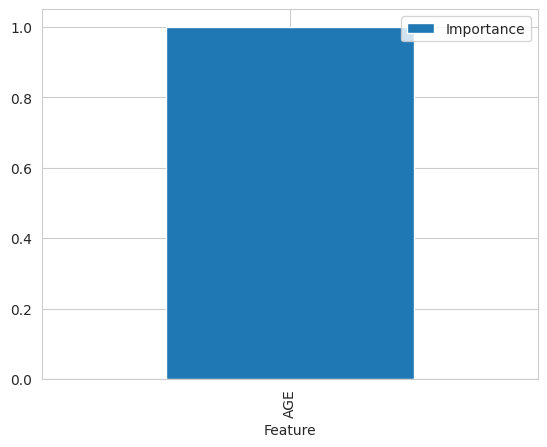

In [45]:
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()

print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate Classifier on Train and Test Sets

Custom Function

In [46]:
from sklearn.metrics import classification_report, confusion_matrix


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

def confusion_matrix_and_report(X, y, pipeline, label_map):
    prediction = pipeline.predict(X)
    
    labels = sorted(set(y) | set(prediction))
    
    cm = confusion_matrix(y_true=y, y_pred=prediction, labels=labels)
    
    cm_df = pd.DataFrame(cm, columns=[f"Predicted {label}" for label in labels],
                            index=[f"Actual {label}" for label in labels])
    
    print('---  Confusion Matrix  ---')
    print(cm_df)
    print("\n")
    
    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=[str(label) for label in labels]))

In [47]:
disc.binner_dict_['AGE']

[-inf, 30.0, 41.0, 48.0, 53.0, 58.0, 63.0, 68.0, 73.0, 80.0, inf]

In [48]:
label_map = [
    '<30.0', 
    '30.0 to 41.0',
    '41.0 to 48.0',
    '48.0 to 53.0',
    '53.0 to 58.0',
    '58.0 to 63.0',
    '63.0 to 68.0',
    '68.0 to 73.0',
    '73.0 to 80.0',
    '>80.0'
]

print(label_map)

['<30.0', '30.0 to 41.0', '41.0 to 48.0', '48.0 to 53.0', '53.0 to 58.0', '58.0 to 63.0', '63.0 to 68.0', '68.0 to 73.0', '73.0 to 80.0', '>80.0']


In [49]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map=label_map)

#### Train Set #### 

---  Confusion Matrix  ---
          Predicted 0  Predicted 1
Actual 0         8699        12328
Actual 1         8040        20721


---  Classification Report  ---
              precision    recall  f1-score   support

           0       0.52      0.41      0.46     21027
           1       0.63      0.72      0.67     28761

    accuracy                           0.59     49788
   macro avg       0.57      0.57      0.57     49788
weighted avg       0.58      0.59      0.58     49788

#### Test Set ####

---  Confusion Matrix  ---
          Predicted 0  Predicted 1
Actual 0         2166         3131
Actual 1         1885         5266


---  Classification Report  ---
              precision    recall  f1-score   support

           0       0.53      0.41      0.46      5297
           1       0.63      0.74      0.68      7151

    accuracy                           0.60     12448
   macro avg       0.58      0.57      0.57     12448
weighted avg       0.59    

#### Which pipeline to choose?

We fitted 3 pipelines:

- Regression
- Regression with PCA
- Classifier

In [50]:
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['SEX', 'INTUBED', 'PNEUMONIA',
                                           'DIABETES', 'COPD', 'ASTHMA',
                                           'INMSUPR', 'HIPERTENSION',
                                           'OTHER_DISEASE', 'CARDIOVASCULAR',
                                           'OBESITY', 'RENAL_CHRONIC',
                                           'TOBACCO', 'ICU'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='vari...
                                          variables=['SEX', 'INTUBED',
                                                     'PNEUMONIA', 'AGE',
                                                     'DIABETES', 'COPD',
                                                     'ASTHMA', 'INMSUPR'

#### Refit pipeline with best features

Rewrite Pipeline

In [52]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(
            encoding_method='arbitrary',
            variables=['INTUBED', 'PNEUMONIA', 'ICU']
        )),
        ("feat_scaling", StandardScaler()),
        ("model", model),
    ])
    return pipeline_base

Define best features

In [53]:
best_features = ['INTUBED', 'AGE', 'PNEUMONIA', 'ICU']

Filter the data to include only the best features

In [54]:
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

Define and fit the pipeline

In [55]:
pipeline_best = PipelineOptimization(LogisticRegression(random_state=0))
pipeline_best.fit(X_train_best, y_train)

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['INTUBED', 'PNEUMONIA', 'ICU'])),
                ('feat_scaling', StandardScaler()),
                ('model', LogisticRegression(random_state=0))])

#### Split Train Test Set, only with best features

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['DIED'], axis=1),
    df_clf['DIED'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train_best.shape, y_train.shape,
      "\n* Test set:", X_test_best.shape, y_test.shape)

* Train set: (49788, 4) (49788,) 
* Test set: (12448, 4) (12448,)


### Save the Model and Artifacts

In [57]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_severity/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/regressor_pipeline.pkl")
print(f'Model saved at {file_path}/regressor_pipeline.pkl')

X_train.to_csv(f"{file_path}/X_train.csv", index=False)
X_test.to_csv(f"{file_path}/X_test.csv", index=False)
y_train.to_csv(f"{file_path}/y_train.csv", index=False)
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_severity/v1'
Model saved at outputs/ml_pipeline/predict_severity/v1/regressor_pipeline.pkl


### Modelling pipeline

ML pipeline for predicting

In [58]:
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['SEX', 'INTUBED', 'PNEUMONIA',
                                           'DIABETES', 'COPD', 'ASTHMA',
                                           'INMSUPR', 'HIPERTENSION',
                                           'OTHER_DISEASE', 'CARDIOVASCULAR',
                                           'OBESITY', 'RENAL_CHRONIC',
                                           'TOBACCO', 'ICU'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='vari...
                                          variables=['SEX', 'INTUBED',
                                                     'PNEUMONIA', 'AGE',
                                                     'DIABETES', 'COPD',
                                                     'ASTHMA', 'INMSUPR'

In [59]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/clf_pipeline.pkl")

['outputs/ml_pipeline/predict_severity/v1/clf_pipeline.pkl']

#### List mapping target levels to ranges

Map for converting numerical variable to categorical variable

In [60]:
label_map

['<30.0',
 '30.0 to 41.0',
 '41.0 to 48.0',
 '48.0 to 53.0',
 '53.0 to 58.0',
 '58.0 to 63.0',
 '63.0 to 68.0',
 '68.0 to 73.0',
 '73.0 to 80.0',
 '>80.0']

In [61]:
joblib.dump(value=label_map, filename=f"{file_path}/label_map.pkl")

['outputs/ml_pipeline/predict_severity/v1/label_map.pkl']

#### Feature importance plot

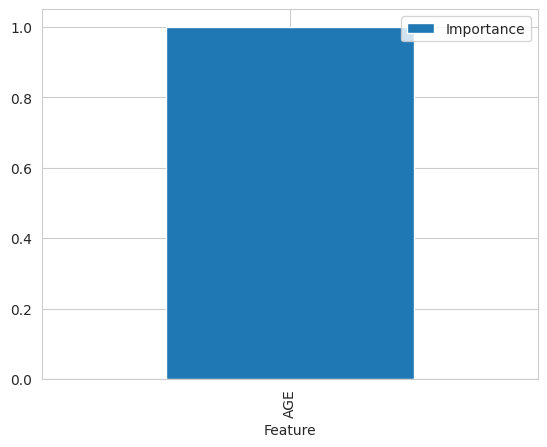

In [65]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

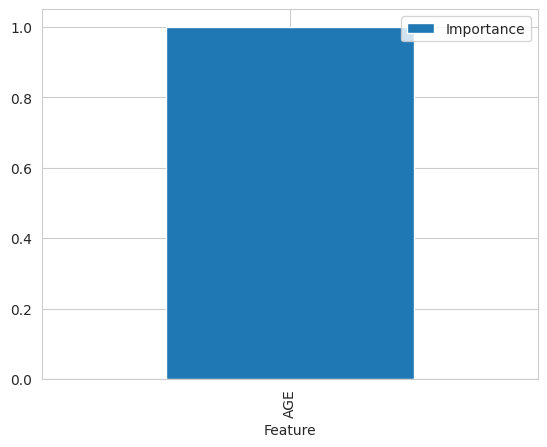

In [63]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')